<a href="https://colab.research.google.com/github/alvinrach/25-Time_Series-Stock_Prediction/blob/main/Stock_Prediction_(WMT)_using_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alvin Rachmat**

**Bidirectional LSTM : Walmart Stock Prediction**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint
from sklearn.model_selection import train_test_split

# This module could faster the plotting of date-value plot
import matplotlib.dates as mdates

In [2]:
# Read daily data from yahoo finance
d=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/WMT?period1=83548800&period2=1625702400&interval=1d&events=history&includeAdjustedClose=true')
d

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.036729,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.036590,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.036172,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.036172,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.035616,870400
...,...,...,...,...,...,...,...
12317,2021-06-30,139.559998,142.580002,138.690002,141.020004,141.020004,15170400
12318,2021-07-01,140.410004,141.250000,139.009995,139.320007,139.320007,8782900
12319,2021-07-02,139.350006,141.080002,139.350006,140.110001,140.110001,8760200
12320,2021-07-06,139.899994,140.750000,139.509995,139.940002,139.940002,6093100


In [3]:
# Check null
e=d.copy()
d.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# MinMax Scaling (Enhances MAE performance a lot)
scaler = MinMaxScaler()
scaler.fit(e.iloc[:,1:2])
d.iloc[:,1:2] = scaler.transform(e.iloc[:,1:2])
d

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.000312,0.064697,0.063477,0.064453,0.036729,2508800
1,1972-08-28,0.000318,0.064941,0.064209,0.064209,0.036590,972800
2,1972-08-29,0.000315,0.063965,0.063477,0.063477,0.036172,1945600
3,1972-08-30,0.000312,0.063477,0.062988,0.063477,0.036172,409600
4,1972-08-31,0.000308,0.062988,0.062500,0.062500,0.035616,870400
...,...,...,...,...,...,...,...
12317,2021-06-30,0.908584,142.580002,138.690002,141.020004,141.020004,15170400
12318,2021-07-01,0.914119,141.250000,139.009995,139.320007,139.320007,8782900
12319,2021-07-02,0.907217,141.080002,139.350006,140.110001,140.110001,8760200
12320,2021-07-06,0.910798,140.750000,139.509995,139.940002,139.940002,6093100


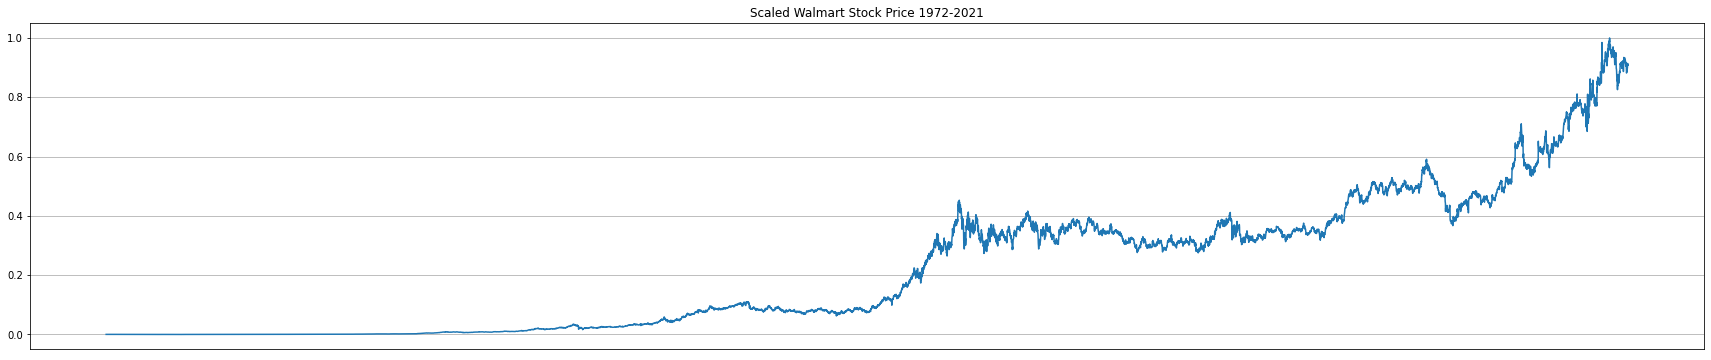

In [5]:
# Here we will just predict open price
X_train = d['Date'].values
y_train  = d['Open'].values

# Plot scaled Walmart Stock Price
fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(X_train,y_train)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_title('Scaled Walmart Stock Price 1972-2021')
plt.grid();

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, shuffle=False)

# Keep the unscaled open price to be compared in the end
y_test_inverse=y_test.reshape(-1,1)
y_test_inverse=scaler.inverse_transform(y_test_inverse)

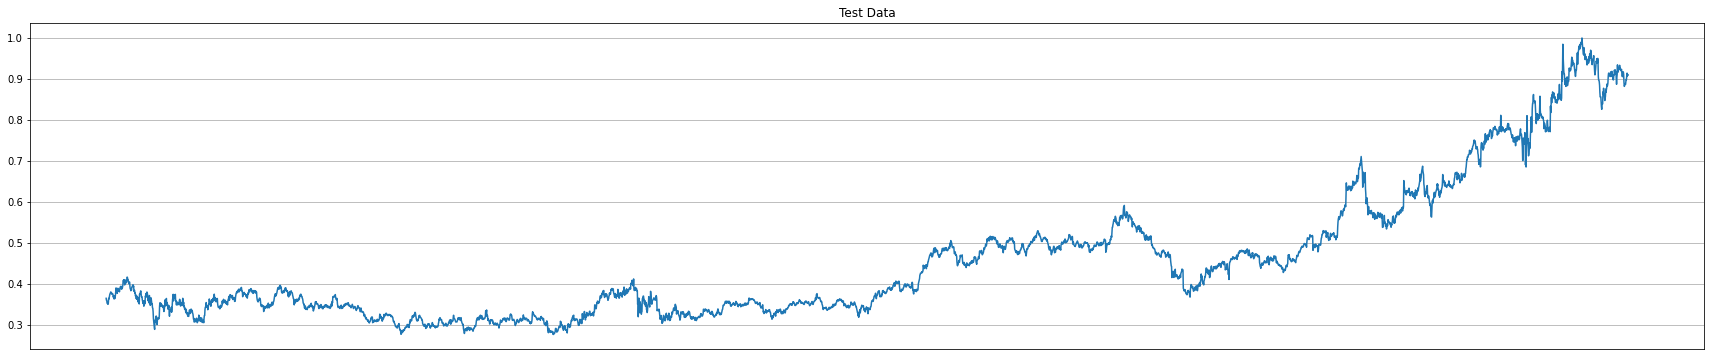

In [6]:
# Plot test data
fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(X_test,y_test)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_title('Test Data')
plt.grid();

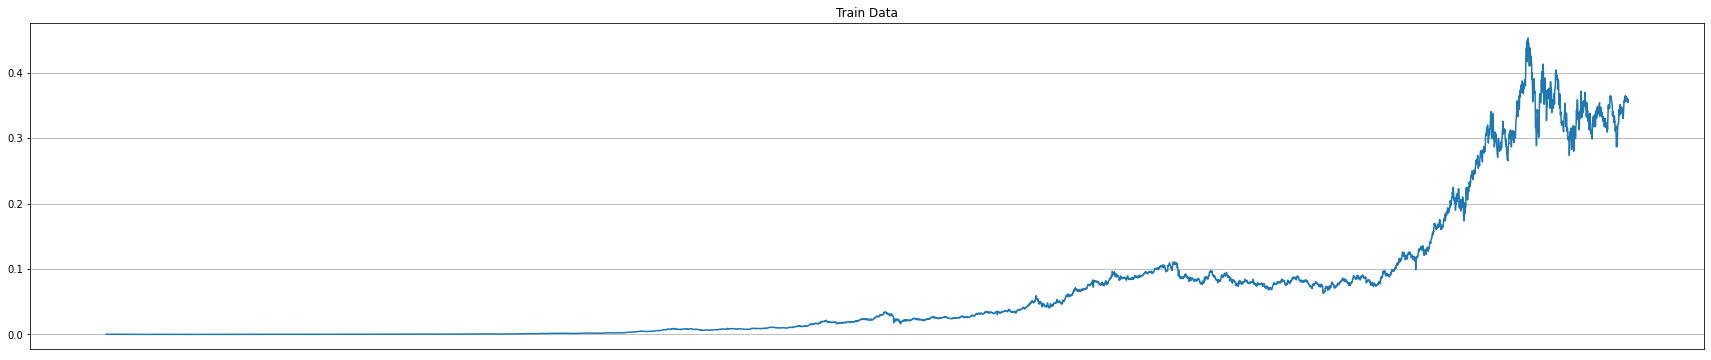

In [7]:
# Plot train data
fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(X_train,y_train)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_title('Train Data')
plt.grid();

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Get the data as tensor
    series = tf.expand_dims(series, axis=-1)

    # Prepare for slicing the data by creating each number as an array tensor
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Sliced every (window_size+1) by shift 1
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

    # Flat the sliced data
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # Shuffle the data (1 means no shuffle) 
    ds = ds.shuffle(shuffle_buffer)

    # Separate each feature and its label    
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    # Return as prefetched data
    return ds.batch(batch_size).prefetch(1)
    # https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [9]:
# Usually prior day of the stock market is really correlated with the tomorrow's price
correlated_day=1

# Do tune the batch size
b_size=200

# Shuffle train data, it enhances the MAE performance
train_set = windowed_dataset(y_train, window_size=correlated_day, batch_size=b_size, shuffle_buffer=1000)

# Don't shuffle test data, so we can plot this easier later
test_set = windowed_dataset(y_test, window_size=correlated_day, batch_size=b_size, shuffle_buffer=1)
test_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)), # Don't add return_sequences=True to the last/only one LSTM/BiLSTM layer
  # tf.keras.layers.LSTM(180, return_sequences=True), 
  # tf.keras.layers.LSTM(120),
  # tf.keras.layers.Dense(90, activation="relu"),
  # tf.keras.layers.Dense(60, activation="relu"),
  # tf.keras.layers.Dense(30, activation="relu"),
  # tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [11]:
# After tune and tune, I found that the mae can reach 0.0042. Make it as the callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mae')<0.0042):
            print("\nMAE has dropped below 0.0042")
            self.model.stop_training = True
set_callback = myCallback()

optimizer = tf.keras.optimizers.Adam(learning_rate=5.0000e-04) #tf.keras.optimizers.SGD(learning_rate=5.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']) #tf.keras.metrics.MeanAbsolutePercentageError()
history = model.fit(train_set, validation_data=test_set, epochs=100, batch_size=8192, callbacks=[set_callback])

Epoch 1/100
37/37 [==============================] - 11s 74ms/step - loss: 0.0043 - mae: 0.0466 - val_loss: 0.0775 - val_mae: 0.3623
Epoch 2/100
37/37 [==============================] - 1s 35ms/step - loss: 0.0047 - mae: 0.0729 - val_loss: 0.0671 - val_mae: 0.3374
Epoch 3/100
37/37 [==============================] - 1s 37ms/step - loss: 0.0040 - mae: 0.0666 - val_loss: 0.0562 - val_mae: 0.3089
Epoch 4/100
37/37 [==============================] - 1s 34ms/step - loss: 0.0032 - mae: 0.0608 - val_loss: 0.0426 - val_mae: 0.2688
Epoch 5/100
37/37 [==============================] - 1s 36ms/step - loss: 0.0024 - mae: 0.0540 - val_loss: 0.0276 - val_mae: 0.2170
Epoch 6/100
37/37 [==============================] - 1s 33ms/step - loss: 0.0016 - mae: 0.0447 - val_loss: 0.0134 - val_mae: 0.1521
Epoch 7/100
37/37 [==============================] - 1s 32ms/step - loss: 7.8195e-04 - mae: 0.0330 - val_loss: 0.0035 - val_mae: 0.0796
Epoch 8/100
37/37 [==============================] - 1s 33ms/step - los

In [12]:
model.predict(test_set)

array([[0.36364082],
       [0.35878965],
       [0.35806865],
       ...,
       [0.91409594],
       [0.90735006],
       [0.91085106]], dtype=float32)

In [13]:
model.evaluate(test_set)

25/25 [==============================] - 1s 21ms/step - loss: 2.1038e-05 - mae: 0.0042


[2.103774568240624e-05, 0.004160727374255657]

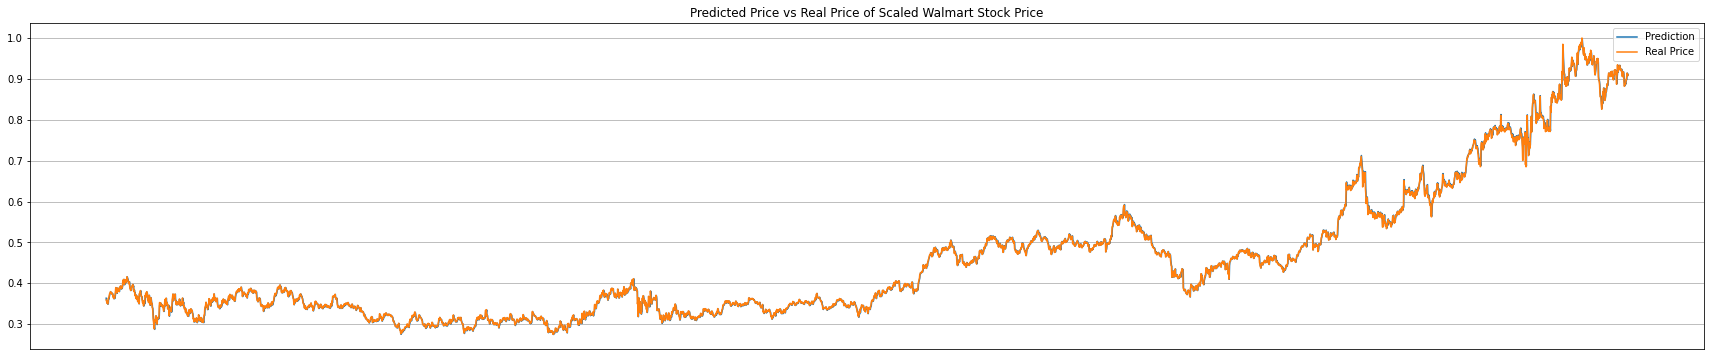

In [14]:
# Plot of the scaled price and prediction

a=len(model.predict(test_set))

fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(X_test[-a:], model.predict(test_set))
plt.plot(X_test[-a:], y_test[-a:])
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.legend(['Prediction','Real Price'])
ax.set_title('Predicted Price vs Real Price of Scaled Walmart Stock Price')
plt.grid();

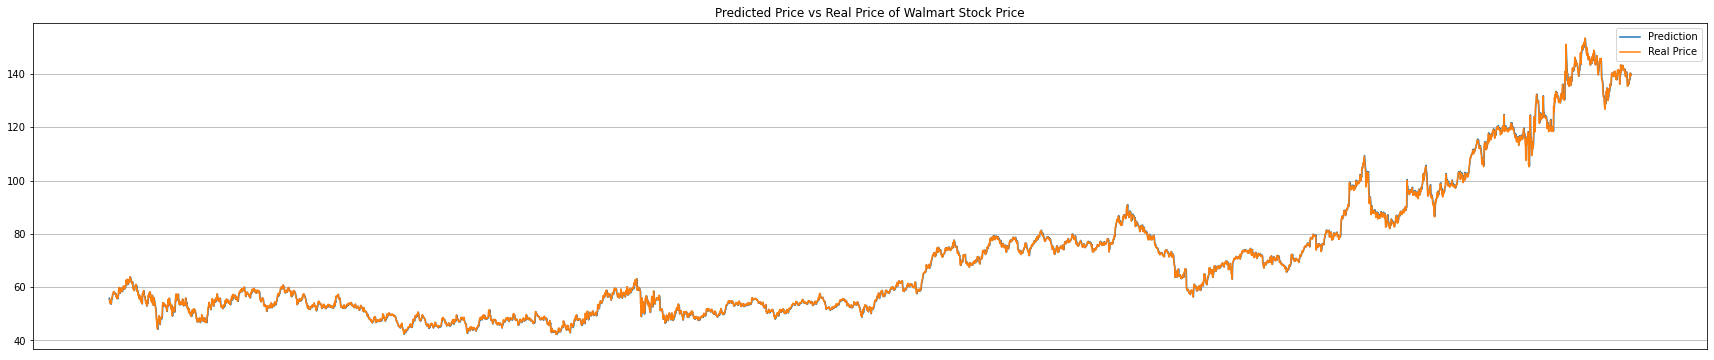

In [15]:
# Plot of the price and prediction
predcit_inverse=model.predict(test_set)
predcit_inverse=scaler.inverse_transform(predcit_inverse)

a=len(predcit_inverse)

fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(X_test[-a:], predcit_inverse)
plt.plot(X_test[-a:], y_test_inverse[-a:])
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.legend(['Prediction','Real Price'])
ax.set_title('Predicted Price vs Real Price of Walmart Stock Price')
plt.grid();

In [16]:
#Calculate the MAE of the unscaled data
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_inverse[-a:], predcit_inverse)

0.6390225987854004

In [17]:
# The prediction for the last date on the dataset(7/7/21)
predcit_inverse[-2]

array([139.37042], dtype=float32)

In [18]:
# The true price for the last date on the dataset(7/7/21)
y_test_inverse[-1]

array([139.759995])

In [19]:
# The prediction for tomorrow's price(8/7/21)
predcit_inverse[-1]

array([139.90813], dtype=float32)

Open price of tomorrow's price (8/7/21)

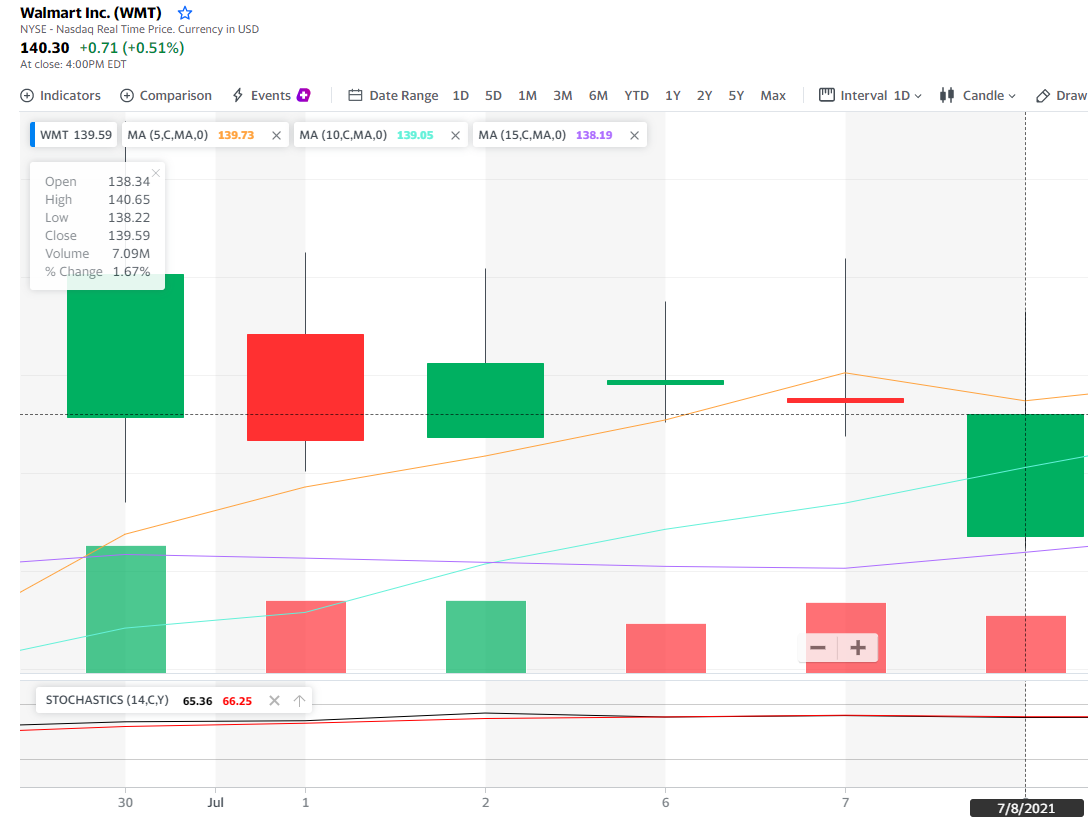

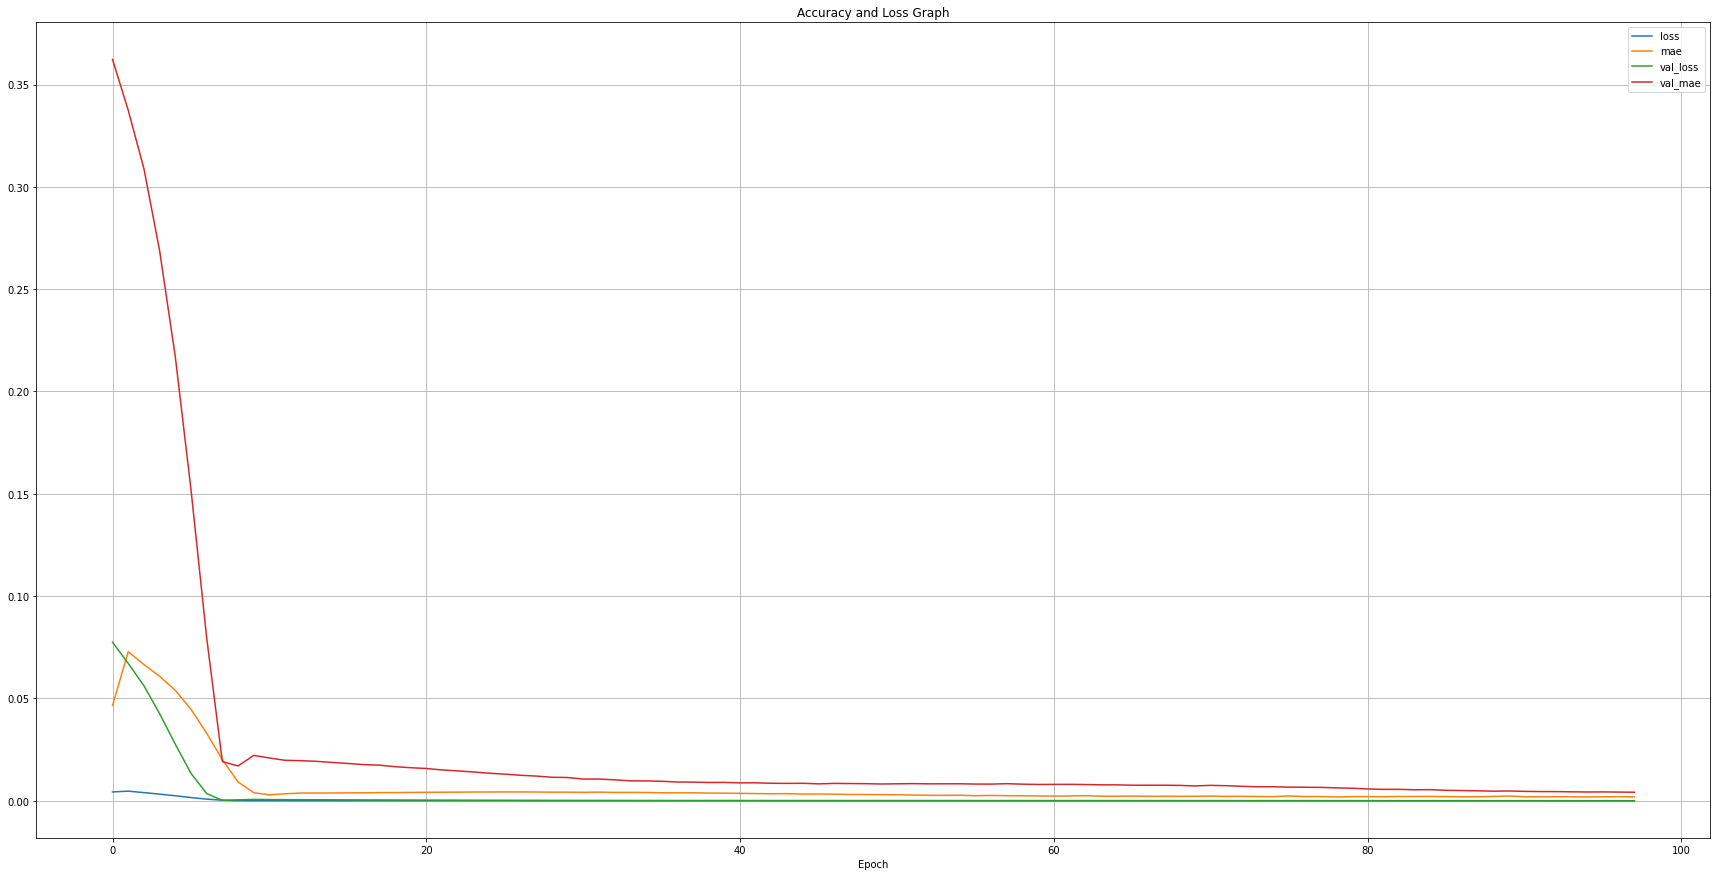

In [20]:
# Plotting loss and accuracy, train and validation, each epoch
pd.DataFrame(history.history).plot(figsize=(30,15))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid();